# [MATH2504 Programming of Simulation, Analysis, and Learning Systems at The University of Queensland](https://courses.smp.uq.edu.au/MATH2504/)

## Semester 2, 2022

# Practical I: Towards Project 3 - Machine Learning

In this practical we explore basic machine learning towards project 3.

The focus is on Logistic Regression for binary classification.

In the previous practical we saw logistic regression for small (few features/variables) using the GLM.jl package. In this practical we'll implement logistic regression from first principles.

# The FashionMNIST dataset

It is similar to MNIST (used in lecture) yet using `classnames()` is more important because the labels are no longer the sequential digits.

In [11]:
using MLDatasets
train_data = FashionMNIST.traindata(Float64)

train_imgs = train_data[1]
@show typeof(train_imgs)
@show size(train_imgs)

train_labels = train_data[2]
@show typeof(train_labels);

typeof(train_imgs) = Array{Float64, 3}
size(train_imgs) = (28, 28, 60000)
typeof(train_labels) = Vector{Int64}


In [16]:
test_data = FashionMNIST.testdata(Float64)
test_imgs = test_data[1]
test_labels = test_data[2]
@show size(test_imgs);

size(test_imgs) = (28, 28, 10000)


In [17]:
class_names = FashionMNIST.classnames()

10-element Vector{String}:
 "T-Shirt"
 "Trouser"
 "Pullover"
 "Dress"
 "Coat"
 "Sandal"
 "Shirt"
 "Sneaker"
 "Bag"
 "Ankle boot"

The first 12 labels: ["Ankle boot", "T-Shirt", "T-Shirt", "Dress", "T-Shirt", "Pullover", "Sneaker", "Pullover", "Sandal", "Sandal", "T-Shirt", "Ankle boot"]


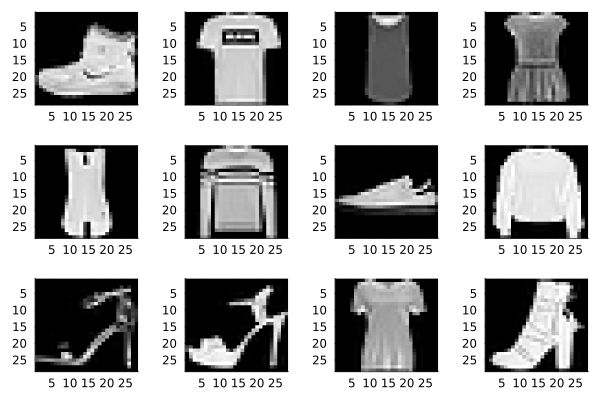

In [60]:
using Plots, Measures, LaTeXStrings
println("The first 12 labels: ", [class_names[k+1] for k in train_labels[1:12]])
plot([heatmap(train_imgs[:,:,k]',
            yflip=true,legend=false,c=cgrad([:black, :white])) for k in 1:12]...)


It is exactly balanced:

In [37]:
using StatsBase
@show counts(train_labels)
@show counts(test_labels);

counts(train_labels) = [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
counts(test_labels) = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


Whereas MNIST is only approximatly balanced:

In [39]:
@show counts(MNIST.traindata(Float64)[2])
@show counts(MNIST.testdata(Float64)[2]);

counts((MNIST.traindata(Float64))[2]) = [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
counts((MNIST.testdata(Float64))[2]) = [980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]


# Lets make a logistic regression classifier to classify between a "Sandal" and an "Ankle Boot"

In [62]:
sandal_index = findfirst(==("Sandal"),class_names) - 1 #the -1 is because indexing starts from 0

5

In [63]:
boot_index = findfirst(==("Ankle boot"),class_names) - 1

9

In [64]:
size(train_imgs)

(28, 28, 60000)

In [65]:
sandal_imgs = train_imgs[:,:,train_labels .== sandal_index];
size(sandal_imgs)

(28, 28, 6000)

In [66]:
boot_imgs = train_imgs[:,:,train_labels .== boot_index];
size(boot_imgs)

(28, 28, 6000)

Here are some Sandals

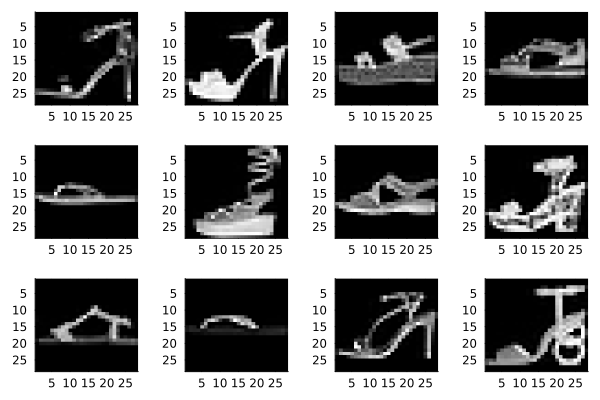

In [69]:
plot([heatmap(sandal_imgs[:,:,k]',
            yflip=true,legend=false,c=cgrad([:black, :white])) for k in 1:12]...)


Here are some boots 

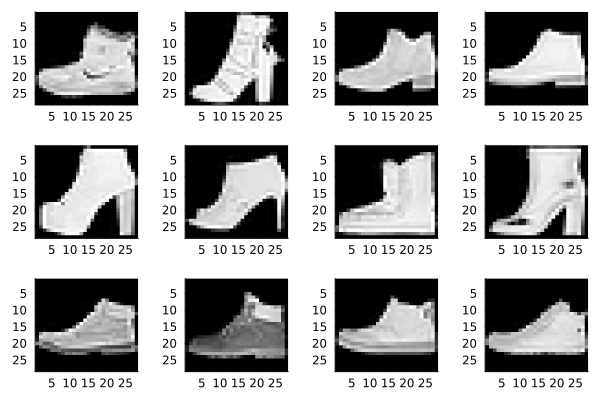

In [70]:
plot([heatmap(boot_imgs[:,:,k]',
            yflip=true,legend=false,c=cgrad([:black, :white])) for k in 1:12]...)


In [76]:
n_sandals_train = last(size(sandal_imgs))

6000

In [77]:
n_boots_train = last(size(boot_imgs))

6000

In [84]:
sandal_imgs_as_vectors = vcat([vec(sandal_imgs[:,:,k])' for k in 1:n_sandals_train]...)
size(sandal_imgs_as_vectors)

(6000, 784)

In [85]:
boot_imgs_as_vectors = vcat([vec(boot_imgs[:,:,k])' for k in 1:n_boots_train]...)
size(boot_imgs_as_vectors)

(6000, 784)

In [90]:
train_data_2_class = vcat(sandal_imgs_as_vectors, boot_imgs_as_vectors)
@show size(train_data_2_class)
heatmap(train_data_2_class,legend=false)

size(train_data_2_class) = (12000, 784)


## Logistic regression model

In [100]:
sig(x) = 1/(1+MathConstants.e^-x)

sig (generic function with 1 method)

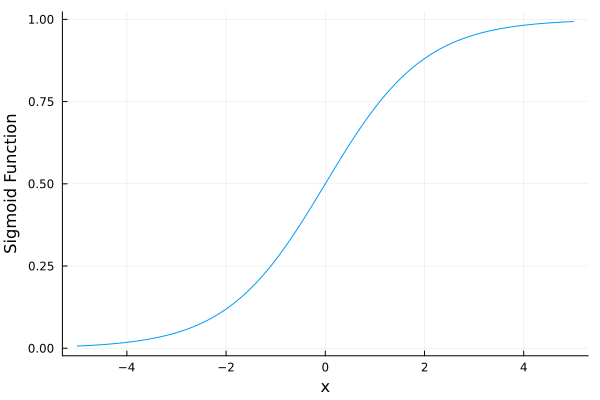

In [105]:
plot(-5:0.1:5,sig.(-5:0.1:5), xlabel = "x", ylabel = "Sigmoid Function",label=false)

In [114]:
using Flux, Random
using Flux: binarycrossentropy #Loss function

In [113]:
Random.seed!(0)

logistic_predict(img_vec, w, b) = sig(w'*img_vec .+ b)
logistic_classifier(img_vec, w, b) = logistic_predict(img_vec, w, b) > 0.5 #Threhsold for predicting a positive sample


function train_logistic(;mini_batch_size = 1000)
    
    #Initilize parameters
    w = randn(28*28)
    b = [randn(1)]

    opt = ADAM(0.01)
    loss(x, y) = binarycrossentropy(logistic_predict(x, w, b), y)

    loss_value = 0.0
    epoch_num = 0

    #Training loop
    while true
        prev_loss_value = loss_value
        
        #Loop over mini-batches in epoch
        start_time = time_ns()
        for batch in Iterators.partition(1:n_train, mini_batch_size)
            gs = gradient(()->loss(X'[:,batch], train_labels[batch]), params(W,b))
            for p in (W,b)
                update!(opt, p, gs[p])
            end
        end
        end_time = time_ns()

        #record/display progress
        epoch_num += 1
        loss_value = loss(X', train_labels)
        println("Epoch = $epoch_num ($(round((end_time-start_time)/1e9,digits=2)) sec) Loss = $loss_value")
        
        if epoch_num == 1 || epoch_num % 5 == 0 
            acc = mean([logistic_sofmax_classifier(X_test'[:,k], W, b) for k in 1:n_test] .== test_labels)
            println("\tValidation accuracy: $acc") 
            
            #Stopping criteria
            abs(prev_loss_value-loss_value) < 1e-3 && break
        end
    end
    return W, b
end

# Train model parameters
w, b = train_logistic();

LoadError: UndefVarError: n_train not defined